In [11]:
"""import packages you need"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset


In [12]:
df1 = pd.read_excel('Machine Learning Data.xlsx')
print(df1.shape)
df1 = shuffle(df1)

df1.dropna(how='any', axis=1, inplace = True) 

print('\nshape of new data frame:')
print(df1.shape)


(189, 8)

shape of new data frame:
(189, 7)


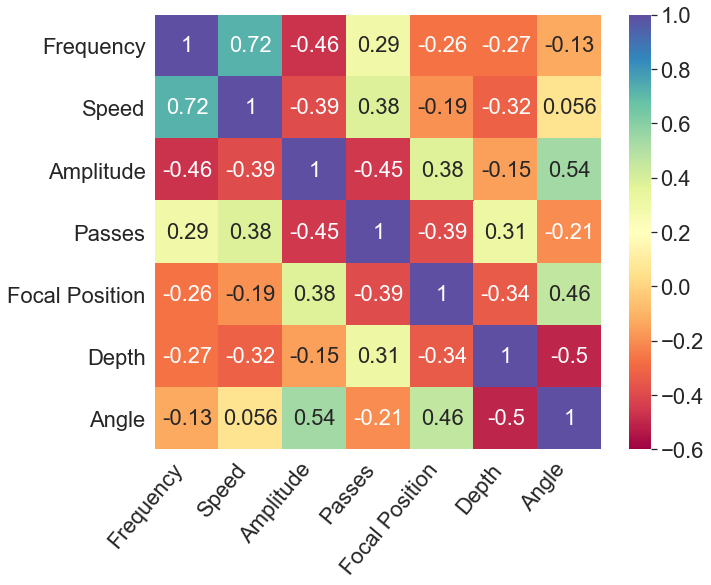

In [13]:
fig= plt.figure(figsize=(10,8))

sns.set(font_scale=2)

heatmap = sns.heatmap(df1.corr(), 
                      annot=True, annot_kws={'size': 22},
                      cmap="Spectral", vmin=-0.6, vmax=1,
                      cbar=True, xticklabels=True)

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        rotation=50, horizontalalignment='right'
                       )

plt.show()

## Preprocessing data

In [14]:
normalizer = MinMaxScaler()   
df_scl = normalizer.fit_transform(df1)

df_scl = pd.DataFrame(df_scl, columns=df1.columns )


In [15]:
X = df_scl.drop(['Depth', 'Angle'], axis = 'columns')
Dpt = df_scl.Depth.values
Ang = df_scl.Angle.values

Xtrain, Xtest,Dpt_train, Dpt_test, Ang_train, Ang_test = train_test_split(X, Dpt, Ang,
                                                test_size = 0.10, random_state = 0)


In [16]:
def mse(y,ypred):
    return np.mean((y-ypred)**2)


def R2(y, predY):
    res = y - predY 
    RSS = sum(res**2)  
    
    res_vs_ave = y - np.mean(y)  
    TSS = sum(res_vs_ave**2)     
    
    return 1-RSS/TSS 


## Defining different models

In [17]:
model1 = Pipeline([
    ('linear_regression', LinearRegression())
])

model2 = Pipeline([   # higher degree causes overfitting
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('linear_regression', LinearRegression())
])


## Apply Lasso or Ridge to reduce the no. of the features
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=11, fit_intercept=True))
])

model4 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', Lasso(alpha=11, fit_intercept=True))
])

model5 = Pipeline([
    ('ridge', Ridge(alpha=11, fit_intercept=True))
])

model6 = Pipeline([
    ('lasso', Lasso(alpha=11, fit_intercept=True))
])

model7 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('XGB', XGBRegressor(max_depth=7,                 # Depth of each tree
                        learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                        n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                        verbosity=1,                  # If to show more errors or not.
                        objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                        booster='gbtree',             # What to boost. Trees in this case.
                        n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                        gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                        subsample=1,              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                        colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                        colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                        colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                        reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                        reg_lambda=0,                 # Regularizer for first fit.
                        scale_pos_weight=1,           # Balancing of positive and negative weights.
                        base_score=0.5,               # Global bias. Set to average of the target rate.
                        random_state=1,        # Seed
                        missing=None                  # How are nulls encoded?
                        ))
])

model8 = Pipeline([
    ('XGB', XGBRegressor(max_depth=7,                 # Depth of each tree
                        learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                        n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                        verbosity=1,                  # If to show more errors or not.
                        objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                        booster='gbtree',             # What to boost. Trees in this case.
                        n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                        gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                        subsample=1,              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                        colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                        colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                        colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                        reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                        reg_lambda=0,                 # Regularizer for first fit.
                        scale_pos_weight=1,           # Balancing of positive and negative weights.
                        base_score=0.5,               # Global bias. Set to average of the target rate.
                        random_state=1,        # Seed
                        missing=None                  # How are nulls encoded?
                        ))
])


In [18]:
"""comparing the cross validation error for different models"""
kf = KFold(n_splits=10,shuffle=True)
# print('The cross validation loss on `Depth` for different models:')

print('\nLinear regression:')
print((-cross_val_score(model1, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nPolynomial + LR:')
print((-cross_val_score(model2, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nPolynomial + Ridge:')
print((-cross_val_score(model3, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nPolynomial + Lasso:')
print((-cross_val_score(model4, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nRidge:')
print((-cross_val_score(model5, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nLasso:')
print((-cross_val_score(model6, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nPolynomial + XGB:')
print((-cross_val_score(model7, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

print('\nXGB:')
print((-cross_val_score(model8, Xtrain, Dpt_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')



Linear regression:
1.5538 %

Polynomial + LR:
0.5758 %

Polynomial + Ridge:
1.6198000000000001 %

Polynomial + Lasso:
2.4885 %

Ridge:
1.8943999999999999 %

Lasso:
2.4866 %

Polynomial + XGB:
0.5881 %

XGB:
0.716 %


## comparing the test loss for selected models with better cross validation error

In [19]:
"""As model2, model7, model8 have close R2 scores, lets compare their test loss"""

Dpt_model2 = model2.fit(Xtrain, Dpt_train)
predict_Dpt = Dpt_model2.predict(Xtest)
print(f'Polynomial + LR test loss :{mse(Dpt_test, predict_Dpt).round(6)*100}%')


#################
Dpt_model7 = model7.fit(Xtrain, Dpt_train)
predict_Dpt = Dpt_model7.predict(Xtest)

print(f'Polynomial + XGB test loss :{mse(Dpt_test, predict_Dpt).round(6)*100}%')


##################
Dpt_model8 = model8.fit(Xtrain, Dpt_train)
predict_Dpt = Dpt_model8.predict(Xtest)

print(f'XGB test loss :{mse(Dpt_test, predict_Dpt).round(6)*100}%')



Polynomial + LR test loss :0.8246%
Polynomial + XGB test loss :1.0987%
XGB test loss :0.7678%


## Neural network model

Initial loss before optimizing the parameters: 17.985127866268158%
Final loss after optimizing parameteres 20 times: 5.320947244763374%


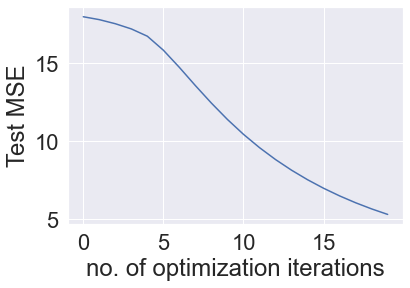

In [28]:
class LinearModel(torch.nn.Module):
    
    def __init__(self, input_size, node_layer, num_classes):
        
        super().__init__()
        
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=node_layer) 
#         self.activation1 = torch.nn.LogSigmoid()
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=node_layer, out_features=node_layer) 
        self.activation2 = torch.nn.ReLU()
        self.dense3 = torch.nn.Linear(in_features=node_layer, out_features=num_classes)
        self.activation3 = torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)       
        X = self.activation1(X)    
        X = self.dense2(X)        
        X = self.activation2(X)
        X = self.dense3(X)        
        X = self.activation3(X)
        return X
    
num_features = 5
num_classes = 1
model = LinearModel(num_features,60, num_classes)

Xt = torch.FloatTensor(Xtrain.values)    
yt = torch.from_numpy(Dpt_train).float()


y_pred = model.forward(Xt) 


# The loss function is also an object with attached derivative 
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
loss = criterion(input=y_pred, target=yt.reshape(-1,1))
print(f'Initial loss before optimizing the parameters: {(loss.item()*100)}%')   # To see the initial loss calculated before optimizing the parameters


# Optimization is implemented in a torch.optim object here we are using stochastic gradient decent (SGD)
# model.parameters() is a link to the parameters of the model,
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

# Now put these together and optimise 
max_iter = 20
Loss = []
for i in range(max_iter):
    # Intialize the gradient 
    optimizer.zero_grad()
   
    y_pred = model.forward(Xt) # Get a forward pass with gradient 
    loss = criterion(input=y_pred, target=yt.reshape(-1,1)) # Caluculate the loss  
    loss.backward() # propagate the derivative backwards 
    optimizer.step() # Take one updating step
#     if i % 1 == 0:
    with torch.no_grad():
        Loss.append(loss.item())
#             
print(f'Final loss after optimizing parameteres {max_iter} times: {(Loss[-1]*100)}%')         
plt.plot(np.array(Loss)*100)
plt.ylabel('Test MSE')
plt.xlabel('no. of optimization iterations')
plt.show()

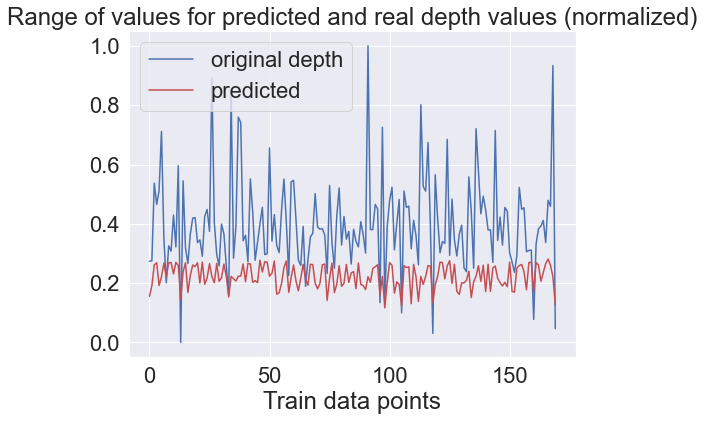

In [29]:
fig = plt.figure(figsize=(8,6))

plt.plot(Dpt_train, color= 'b', label = 'original depth')
plt.plot(y_pred.detach().numpy().ravel(), color='r', label = 'predicted')

plt.xlabel('Train data points')
plt.title('Range of values for predicted and real depth values (normalized)')
plt.legend()

In [30]:
Xtst = torch.FloatTensor(Xtest.values)    

with torch.no_grad():
    # train the optimized model with training data, predict its ypred

    y_pred = model.forward(Xt) 
    print(f'MSE train: {(mse(Dpt_train, y_pred.numpy().ravel())*100).round(6)},%')
    print(f'R2 train: {(R2(Dpt_train, y_pred.numpy().ravel())).round(6)}')

    print('\n *******************\n')
    
    # use the optimized and trained model on tests data to predict depth
    y_pred_test = model.forward(Xtst)
    print(f'MSE test: {(mse(Dpt_test, y_pred_test.numpy().ravel())*100).round(6)},%')
    print(f'R2 test: {(R2(Dpt_test, y_pred_test.numpy().ravel())).round(6)}')


MSE train: 5.00417,%
R2 train: -1.032866

 *******************

MSE test: 2.758779,%
R2 test: -0.588207


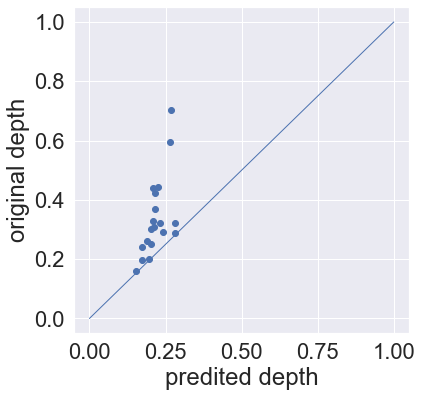

In [31]:
fig = plt.figure(figsize=(6,6))

plt.scatter(y=Dpt_test, x=y_pred_test.numpy().ravel())
x=np.linspace(0,1,10)
plt.plot(x,x*(x>0),linewidth=1)
plt.xlabel('predited depth')
plt.ylabel('original depth')
plt.show()